#### Notebook 3 - Sport event database
Streaming of high hype sport events (particularly football matches) is creating some additional stress on network capacity.
Topic became even more of interest when a pure internet broadcaster acquired the right for serie A matches for next season. 
The project is about some numerical investigation on the relationship between traffic growth on a mobile network in Italy and the scheduling of football matches involving italian teams. Specifically, investigation will address the following questions:

- Can we identify a significative numerical correlation between mobile traffic peaks and footbal matches schedule?
- If yes, can we add insigth for classes of football event parameters showing higher correlations (e.g. number of contemporary matches, hype of a single match, types of broadcaster)? 
- Can the information above be used to tune traffic growth forecasts on a mobile network?

The activity is intended as an investigation exercise, so data actually used, though obtained from real measurement, will first be normalized to range between artificially set bounds. 

#### Datasets

The notebook will leverage on following data:

- Some real traffic measurement from a mobile network on a generic geographical area in Italy over about 2 years. Data are normalized in a way that reduces all used kpi to range between 1 and 2. Only normalized and region wide values are shown.
- Scheduling of major footbal competitions involving italian teams (I considered 'Serie A' and 'Champions League')
- Information about the broadcaster distribuiting the matches (internet only or pay tv+internet)

#### Notebook organization
Activity is organized into different jupyter notebooks:
- The first notebook  is about preparing reading traffic data and adding normalization. As actual starting data will not be shared, this notebook is only intended for reference
- The second notebook will analize and prepare normalized data for actual usage 
- Third notebook (the present one) reads, manipulates and prepare sport events dataframe
- Fourth notebook  merges all collected and preprocessed data and investigate relationship to try to answer the target questions

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

Information about football matches are available on different sites on the internet. Here I used info available at 'footystats.org'.

As first step, available info were donloaded and saved as csv file using external tools and stored in alist of files. Below some sample

In [136]:
cd "C:\\Users\\rpaglin\\OneDrive - Vodafone Group\\Desktop\\Nanodegree prj1 data"

C:\Users\rpaglin\OneDrive - Vodafone Group\Desktop\Nanodegree prj1 data


In [137]:
cd "Footystat Data"

C:\Users\rpaglin\OneDrive - Vodafone Group\Desktop\Nanodegree prj1 data\Footystat Data


In [138]:
SerieA1819=pd.read_csv('SerieA1819.csv')

In [139]:
SerieA1819.head()

,Date,Home,Away,Year
0,"Apr 13, 3:00pm",SPAL,Juventus,2019
1,"Apr 13, 6:00pm",Roma,Udinese,2019
2,"Apr 13, 8:30pm",AC Milan,Lazio,2019
3,"Apr 14, 12:30pm",Torino,Cagliari,2019
4,"Apr 14, 3:00pm",Fiorentina,Bologna,2019


In [140]:
SerieA1819.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
Date    380 non-null object
Home    380 non-null object
Away    380 non-null object
Year    380 non-null int64
dtypes: int64(1), object(3)
memory usage: 12.0+ KB


In [141]:
SerieA1819['Date'].head(5)

0     Apr 13, 3:00pm
1     Apr 13, 6:00pm
2     Apr 13, 8:30pm
3    Apr 14, 12:30pm
4     Apr 14, 3:00pm
Name: Date, dtype: object

'Date' column is particularly important as it contains the info needed to associate a specific event to network data (date and starting time). I prepared a dedicated function to read the different files and concatenate them into a dedicated pandas dataframe, also extracting info in the 'Date' and saving them in different columns

In [142]:
def read_football_result(path,filelist,competition):
    
    """ 
    INPUT
    path: path where input files are stored
    filelist: python list including filenames to be read. Each file contains information about footbal matches, including teams involved and 
    competition: string to be associated to the list of data
    
    OUTPUT
    a pandas dataframe including values read from filelist after some manipulation
    
    The function perform the following tasks:
    1. Read each file in 'filelist' from directory 'path'. Each file i assumed to be a csv file
    2. Manipulate the string containing the date and create different columns for date, year, month, day, hour and min
    3. Create a new column named 'competition' filled with the string in the function parameter
    """

    mdict={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
          'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    ddict = ("Mon","Tue","Wed","Thu","Fri","Sat","Sun")
    dflist=[]
    for fl in filelist:
        df=pd.read_csv(path+fl)
        dflist.append(df)
    df=pd.concat(dflist, ignore_index=True, axis=0)
    df1=pd.DataFrame(df['Date'].str.split(' ').tolist(), columns=['Month','Day','Hour'])
    df=pd.concat([df, df1], axis=1)
    df1=pd.DataFrame(df['Hour'].str.split(':').tolist(), columns=['Hour','Min'])
    df['Pm']=df1['Min'].apply(lambda x: x[-2:]=='pm')
    df['Min']=df1['Min'].apply(lambda x: int(x[:-2]))
    df['Hour']=df1['Hour'].apply(lambda x: int(x))
    df['Day'] = df['Day'].str[:-1]
    df['Day']=df['Day'].apply(lambda x:int(x))
    df['Month']=df['Month'].apply(lambda x:mdict[x])
    df['Date']=pd.to_datetime(df[['Year','Month','Day']],errors='coerce')
    df['Day of week']=df['Date'].apply(lambda x:ddict[x.weekday()])
    df['Competition']=competition
    return df
    

In [143]:
path="C:\\Users\\rpaglin\\OneDrive - Vodafone Group\\Desktop\\Nanodegree prj1 data\\Footystat Data\\"

#Create dataframe for Champions league matches
filelist=['CL1819.csv','CL1920.csv','CL2021.csv']
CL=read_football_result(path,filelist,'ChampionsLeague')

#Create dataframe for SerieA matches matches
filelist=['SerieA1819.csv','SerieA1920.csv','SerieA2021.csv']
SerieA=read_football_result(path,filelist,'SerieA')

In [144]:
SerieA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 11 columns):
Date           1140 non-null datetime64[ns]
Home           1140 non-null object
Away           1140 non-null object
Year           1140 non-null int64
Month          1140 non-null int64
Day            1140 non-null int64
Hour           1140 non-null int64
Pm             1140 non-null bool
Min            1140 non-null int64
Day of week    1140 non-null object
Competition    1140 non-null object
dtypes: bool(1), datetime64[ns](1), int64(5), object(4)
memory usage: 90.3+ KB


In [145]:
CL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 11 columns):
Date           369 non-null datetime64[ns]
Home           369 non-null object
Away           369 non-null object
Year           369 non-null int64
Month          369 non-null int64
Day            369 non-null int64
Hour           369 non-null int64
Pm             369 non-null bool
Min            369 non-null int64
Day of week    369 non-null object
Competition    369 non-null object
dtypes: bool(1), datetime64[ns](1), int64(5), object(4)
memory usage: 29.3+ KB


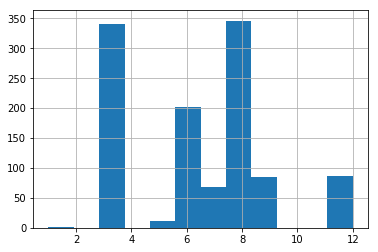

In [148]:
SerieA['Hour'].hist(bins=12)

In [149]:
SerieA['Day of week'].value_counts()

Sun    538
Sat    302
Wed    134
Mon     68
Fri     44
Tue     29
Thu     25
Name: Day of week, dtype: int64

In [150]:
CL['Day of week'].value_counts()

Wed    181
Tue    178
Sat      5
Fri      3
Thu      1
Sun      1
Name: Day of week, dtype: int64

In [151]:
CL[CL['Day of week']=="Sat"]

,Date,Home,Away,Year,Month,Day,Hour,Pm,Min,Day of week,Competition
0,2019-06-01,Tottenham Hotspur,Liverpool,2019,6,1,9,True,0,Sat,ChampionsLeague
128,2020-08-15,Manchester City,Olympique Lyonnais,2020,8,15,9,True,0,Sat,ChampionsLeague
132,2020-08-08,FC Barcelona,Napoli,2020,8,8,9,True,0,Sat,ChampionsLeague
133,2020-08-08,Bayern München,Chelsea,2020,8,8,9,True,0,Sat,ChampionsLeague
244,2021-05-29,Manchester City,Chelsea,2021,5,29,9,True,0,Sat,ChampionsLeague


In [152]:
CL.head(5)

,Date,Home,Away,Year,Month,Day,Hour,Pm,Min,Day of week,Competition
0,2019-06-01,Tottenham Hotspur,Liverpool,2019,6,1,9,True,0,Sat,ChampionsLeague
1,2019-05-08,Ajax,Tottenham Hotspur,2019,5,8,9,True,0,Wed,ChampionsLeague
2,2019-05-07,Liverpool,FC Barcelona,2019,5,7,9,True,0,Tue,ChampionsLeague
3,2019-05-01,FC Barcelona,Liverpool,2019,5,1,9,True,0,Wed,ChampionsLeague
4,2019-04-30,Tottenham Hotspur,Ajax,2019,4,30,9,True,0,Tue,ChampionsLeague


In [153]:
SerieA.head(5)

,Date,Home,Away,Year,Month,Day,Hour,Pm,Min,Day of week,Competition
0,2019-04-13,SPAL,Juventus,2019,4,13,3,True,0,Sat,SerieA
1,2019-04-13,Roma,Udinese,2019,4,13,6,True,0,Sat,SerieA
2,2019-04-13,AC Milan,Lazio,2019,4,13,8,True,30,Sat,SerieA
3,2019-04-14,Torino,Cagliari,2019,4,14,12,True,30,Sun,SerieA
4,2019-04-14,Fiorentina,Bologna,2019,4,14,3,True,0,Sun,SerieA


On top of footbal data, we want to add some additional info that might be correlated to overal throughput, namely hype of the match and kind of broadcaster 

#### Managing categorical variables
To manage the categorical information contained in the matches dataframe, we want to define a new information set with the following numerical values, per each hour in the analysis period:
- Number of Serie A matches ongoing in the hour
- Number of CL matches ongoing in the hour
- Hype of the events in a specific hour (we define some ad hoc hype functions)

To be added later:
- Number of matches broadcasted by internet-only broadcaster
- Number of matches broadcasted by payTv + internet broadcaster



Let's start with hype definition

In [154]:
SerieA.head()

,Date,Home,Away,Year,Month,Day,Hour,Pm,Min,Day of week,Competition
0,2019-04-13,SPAL,Juventus,2019,4,13,3,True,0,Sat,SerieA
1,2019-04-13,Roma,Udinese,2019,4,13,6,True,0,Sat,SerieA
2,2019-04-13,AC Milan,Lazio,2019,4,13,8,True,30,Sat,SerieA
3,2019-04-14,Torino,Cagliari,2019,4,14,12,True,30,Sun,SerieA
4,2019-04-14,Fiorentina,Bologna,2019,4,14,3,True,0,Sun,SerieA


In [155]:
    #We assume that the interest of a match is greater if at least one of major italian team is involved
    #We also define a potential hype for competition (not used at start)
    
    hype_teams={'AC Milan':2, 'Juventus':2, 'Inter Milan':2, 'Roma':2,'Lazio':2,'Napoli':2, 'Atalanta':2, 
                'OthersSA':1, 'OthersCL':0 }
    hype_competitions={'SerieA':1, 'ChampionsLeague':1}


In [156]:
def Hype_x_match(home,away,competition, hype_teams,hype_competitions):
 
    """ 
    The function associates an 'hype value' to a match based on contending teams and the championship of the match
    INPUT
    home: the team playig at home (string)
    away: guest team (string)
    competition: 'SerieA' or 'Champion League'
    hype_teams: dictionary matching a team name with an hype weight
    hype_competition: dictionary matching a competition name with an hype weight
    
    OUTPUT
    an integer representing the 'hype' of the match calculated as the product of team per competition hype 
    """   
    h=0
    for team in [away, home]:
        try: h+=hype_teams[team]
        except: 
            if competition=='SerieA': h+=hype_teams['OthersSA']
            elif competition=='ChampionsLeague': h+=hype_teams['OthersCL']
    try: m=hype_competitions[competition]
    except: 
        m=0    
    return h*m
        

In [159]:
#some sample for testing:
print('AC Milan - Juventus , SerieA: ', Hype_x_match('AC Milan','Juventus','SerieA',hype_teams,hype_competitions))
print('Avellino - Juventus , SerieA: ', Hype_x_match('Avellino','Juventus','SerieA',hype_teams,hype_competitions))
print('Avellino - Palermo , SerieA: ', Hype_x_match('Avellino','Palermo','SerieA',hype_teams,hype_competitions))
print('AC Milan - Juventus , CL: ', Hype_x_match('AC Milan','Juventus','ChampionsLeague',hype_teams,hype_competitions))

AC Milan - Juventus , SerieA:  4
Avellino - Juventus , SerieA:  3
Avellino - Palermo , SerieA:  2
AC Milan - Juventus , CL:  4


Once we know the hype of a specific match, we want to calculate the hours in the calendar when we have a match with a specific hype.
Following function execute this task

In [160]:
def hyped_hours(Hour, Min, Pm):
    """ 
    INPUT
    Hour: integer, representing the hour when the match started
    Min: integer, representing the minute when the match started
    Pm: Boolean (True if hour is to be considered PM)
    
    OUTPUT
    a series of integers, representing the couple of hours mostly impacted by the match. 
    For simplicity we ignore cases where the match finishes the day after (no such case in hour match db)  
    """   
    h=[]
    h1=Hour
    if Pm and Hour<12: h1+=12
    h2=h1+1
    if Min>40:h1,h2=h1+1,h2+1
    if h1<24:h.append(h1) 
    if h2<24:h.append(h2) 
    return h
        

In [161]:
print('A match starting at 15:05 :',hyped_hours(3,5,True))
print('A match starting at 11:55 :',hyped_hours(11,55,False))
print('A match starting at 22:55 (we accept a mistake here):',hyped_hours(10,55,True))

A match starting at 15:05 : [15, 16]
A match starting at 11:55 : [12, 13]
A match starting at 22:55 (we accept a mistake here): [23]


Finally, we create a new dataframe with the following columns:
- DATE: Datetime, representing a date in the period under analysis
- TIME: Integer, representing an hour in the period under analysis
- SerieA: Boolean, representing presence of a SerieA match in the DATE/TIME slot
- Champions League: Boolean, representing presence of a CL match in the DATE/TIME slot
- Hype: Hype value for the match
- Home, Away: string, teams involved in the match

In [163]:
def Hype_x_hour(Matches, hype_teams,hype_competitions):
    """
    INPUT
    Matches: Dataframe of all matches (SA+CL) 
    hype_teams,hype_competitions: dictionaries, defining hype assumptions per team/championship 
    
    OUTPUT
    A new DF with  following columns:
    DATE: Datetime, representing a date in the period under analysis
    TIME: Integer, representing an hour in the period under analysis
    SerieA: Boolean, representing presence of a SerieA match in the DATE/TIME slot
    Champions League: Boolean, representing presence of a CL match in the DATE/TIME slot
    Hype: Hype value for the match
    Home, Away: string, teams involved in the match    """   
    
    hypelist=[]
    for i in Matches.index:
        hype=Hype_x_match(Matches.loc[i]['Home'],Matches.loc[i]['Away'],Matches.loc[i]['Competition'],hype_teams,hype_competitions)
        if hype>0:
            hhlist=hyped_hours(Matches.loc[i]['Hour'],Matches.loc[i]['Min'],Matches.loc[i]['Pm'])
            for h in hhlist:
                d={'DATE':Matches.loc[i]['Date'],
                   'TIME':h,
                   'SerieA':Matches.loc[i]['Competition']=='SerieA',
                   'ChampionsLeague':Matches.loc[i]['Competition']=='ChampionsLeague',
                   'Hype':hype,
                   'Home':Matches.loc[i]['Home'],
                   'Away':Matches.loc[i]['Away'] }
                hypelist.append(d)
    return pd.DataFrame(hypelist)
        


In [164]:
HypeDf=Hype_x_hour(pd.concat([CL,SerieA], axis=0,ignore_index=True),hype_teams,hype_competitions)

In [165]:
HypeDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 7 columns):
Away               2462 non-null object
ChampionsLeague    2462 non-null bool
DATE               2462 non-null datetime64[ns]
Home               2462 non-null object
Hype               2462 non-null int64
SerieA             2462 non-null bool
TIME               2462 non-null int64
dtypes: bool(2), datetime64[ns](1), int64(2), object(2)
memory usage: 101.1+ KB


In [166]:
HypeDf.tail(15)

,Away,ChampionsLeague,DATE,Home,Hype,SerieA,TIME
2447,Udinese,False,2020-09-27,Hellas Verona,2,True,16
2448,Genoa,False,2020-09-27,Napoli,3,True,18
2449,Genoa,False,2020-09-27,Napoli,3,True,19
2450,AC Milan,False,2020-09-27,Crotone,3,True,18
2451,AC Milan,False,2020-09-27,Crotone,3,True,19
2452,Juventus,False,2020-09-27,Roma,4,True,21
2453,Juventus,False,2020-09-27,Roma,4,True,22
2454,Parma,False,2020-09-28,Bologna,2,True,21
2455,Parma,False,2020-09-28,Bologna,2,True,22
2456,Inter Milan,False,2020-09-30,Benevento,3,True,18


As a last step

In [167]:
HypeDf=HypeDf.groupby(by=['DATE','TIME'],axis=0).sum()

In [169]:
HypeDf[HypeDf['ChampionsLeague']>0].head()

ChampionsLeague  Hype  SerieA
DATE       TIME                               
2018-09-18 19                1.0     2     0.0
           20                1.0     2     0.0
           21                1.0     2     0.0
           22                1.0     2     0.0
2018-09-19 21                2.0     4     0.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000142A8B69278>,
      dtype=object)

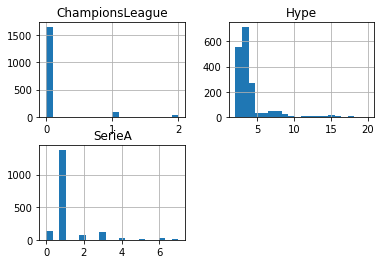

In [132]:
HypeDf.hist(bins=20)

#### Conclusion of this step
HypeDf is the numerical dataframe that should represent categorical variables given as an input. Next step is to analyse if the info calculated so far have an actual correlation on nw throughput and if they can possibly support a better traffic forecast process.
Information about broadcaster have not been inserted, we will come back on this info after having some glance about usefulnes of what done so far

In [170]:
HypeDf.to_csv('C:\\Users\\rpaglin\\OneDrive - Vodafone Group\\Desktop\\Nanodegree prj1 data\\HypeDf.csv')

In [171]:
HypeDf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1787 entries, (2018-08-18 00:00:00, 18) to (2021-05-23 00:00:00, 22)
Data columns (total 3 columns):
ChampionsLeague    1787 non-null float64
Hype               1787 non-null int64
SerieA             1787 non-null float64
dtypes: float64(2), int64(1)
memory usage: 50.4 KB


#### Final step in the "Traffic correlation" notebook